In [1]:
from datetime import datetime,timedelta
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds, wrmds
import pych.ecco as pe
import ecco_v4_py as ecco
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy import stats

from pych.plot import nice_inward_ticks

In [190]:
plt.rcParams.update({'font.size':18,'axes.labelsize':18,'axes.titlesize':22,'text.usetex':True})
rc('text.latex', preamble=r'\usepackage{color}')

### Load up the ECCO output files and make dataset

In [3]:
# messed up the mask sign...
uvel = -np.squeeze(rdmds('../mdsfiles/euc_out.02.0000000001'))
vvel = -np.squeeze(rdmds('../mdsfiles/euc_out.03.0000000001'))

In [4]:
ntime = len(uvel)
ecco_time = np.array([np.datetime64(x) for x in datetime(1992,1,1,12)+(np.arange(ntime)+1)*timedelta(hours=1)])

In [5]:
eds = xr.Dataset()
eds['time'] = xr.DataArray(ecco_time,coords={'time':ecco_time},dims=('time',))

In [6]:
eds['uvel'] = xr.DataArray(100*uvel,coords=eds.time.coords,dims=eds.time.dims,
                          attrs={'description':'Hourly Zonal Velocity',
                                 'Depth':'75m',
                                 'lon':'140W',
                                 'lat':'Averaged between 2 grid cells at ~.2 N/S',
                                 'units':'cm/s'})
eds['vvel'] = xr.DataArray(100*vvel,coords=eds.time.coords,dims=eds.time.dims,
                          attrs={'description':'Hourly Zonal Velocity',
                                 'Depth':'75m',
                                 'lon':'Averaged between 2 grid cells at 139.5W and 140.5W ',
                                 'lat':'0N',
                                 'units':'cm/s'})

### Load up ADCP dataset

In [7]:
adcp = xr.open_dataset('/mnt/data/datasets/tao_triton/adcp0n140w_hr.cdf')
tslice = slice('1996-09-01','2000-01-01')
adcp = adcp.sel(lon=220,lat=0,depth=75).sel(time=tslice)
adcp = adcp.rename({'u_1205':'uvel','v_1206':'vvel'})

In [146]:
print(adcp.time[0].values)
print(adcp.time[-1].values)

1996-09-04T01:00:00.000000000
2000-01-01T23:00:00.000000000


In [145]:
print(eds.time[0].values)
print(eds.time[-1].values)

1992-01-01T13:00:00.000000000
2000-01-06T04:00:00.000000000


In [9]:
def replace_nans(ds,fld):
    ds[fld] = xr.where(ds[fld]==ds.missing_value,np.NAN,ds[fld])
    return ds[fld]

In [10]:
for f in adcp.data_vars:
    adcp[f] = replace_nans(adcp,f)

In [11]:
fake_for_xaxis = xr.where(np.isnan(adcp.uvel),0.,adcp.uvel)

### Get the two only at the same time stamps

In [66]:
time_match = adcp.dropna('time').time==eds.dropna('time').time
Nt = time_match.sum()
for f in ['uvel','vvel']:
    eds[f] = eds[f].where(time_match)
    adcp[f] = adcp[f].where(time_match)

In [46]:
tablestuff=[]
for fld in ['uvel','vvel']:
    # do some computations for table
    diff_squared = (adcp[fld]-eds[fld])**2
    rmsdstr = '%.2f' % np.sqrt( diff_squared.sum()/Nt )
    for ds,rmsd in zip([adcp,eds],[rmsdstr,None]):
        comps =  ['%.2f' % ds[fld].mean().values,
                  '%.2f' % ds[fld].min().values,
                  '%.2f' % ds[fld].max().values,
                  '%.2f' % ds[fld].std().values,
                  '%.2f' % stats.skew(ds[fld].values,nan_policy='omit').data,
                  '%.2f' % stats.kurtosis(ds[fld].values,nan_policy='omit'),
                  rmsd] # last for RMSD ... coming soon
        tablestuff.append(comps)

In [126]:
plt.rcParams.update({'lines.linewidth':.5})

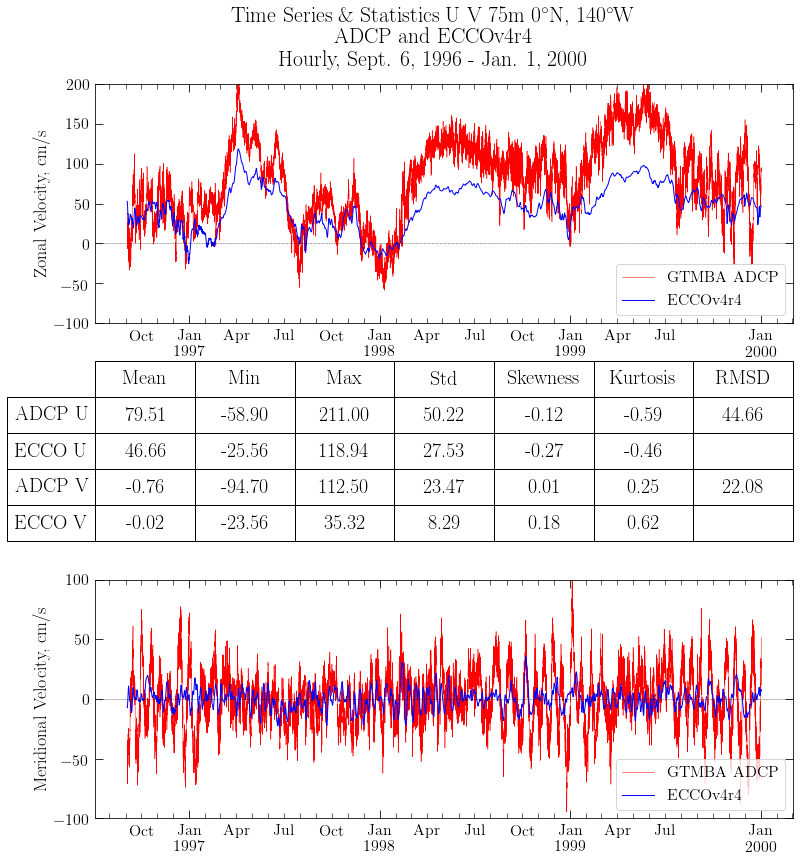

In [191]:
fig,axs = plt.subplots(3,1,figsize=(6.25*2,2.25*6),
                       gridspec_kw={
                           'height_ratios': [1.75,1.25, 1.75]})

for fld,ax,lbl,ylim in zip(['uvel','vvel'],
                           axs[[0,2]],
                           ['Zonal Velocity, cm/s','Meridional Velocity, cm/s'],
                          [[-100,200],[-100,100]]):
    adcp[fld].plot(ax=ax,color='red',label='GTMBA ADCP',linewidth=.5)
    eds[fld].sel(time=tslice).plot(ax=ax,color='blue',label='ECCOv4r4',linewidth=1)

    # add line at y=0
    ax.axhline(y=0,alpha=.7,color='black',linestyle='--')
    
    # Plot formatting
    ax.set(xlabel='',ylabel=lbl,
           ylim=ylim,#xlim=["1996-01-01","1998-12-31"],
           title='')

    # Date formatting for x-axis
    date_form = DateFormatter("%b \n%Y")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(date_form)
    
    ax.tick_params(direction='in',which='major',length=8,top=True,right=True,pad=6)
    ax.tick_params(direction='in',which='minor',length=5,top=True,right=True,pad=6)
    ax.legend(loc='lower right')
    ax.set_xticklabels(['','','Oct','','','','','Apr','','','Jul']*3,minor=True)
    for label in ax.xaxis.get_ticklabels():
        label.set_horizontalalignment('center')
        label.set_rotation(0)
    
columns = ['Mean','Min','Max','Std','Skewness','Kurtosis','RMSD']
table = axs[1].table(tablestuff,
             rowLabels=['ADCP U','ECCO U','ADCP V','ECCO V'],colLabels=columns,
             loc='center',rowLoc='center',cellLoc='center')
axs[1].axis('off')
table.set_fontsize(20)
table.scale(1, 3)

fig.suptitle(r'Time Series \& Statistics U V 75m 0$^\circ$N, 140$^\circ$W' + \
             '\nADCP and ECCOv4r4'+'\nHourly, Sept. 6, 1996 - Jan. 1, 2000',y=.96);
fig.savefig('../figures/adcp_eccov4r4_hourly_140w_75m_1996-2000.png')

## Regression

In [67]:
from scipy import stats

/workspace/anaconda3/envs/py37_tim/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/workspace/anaconda3/envs/py37_tim/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


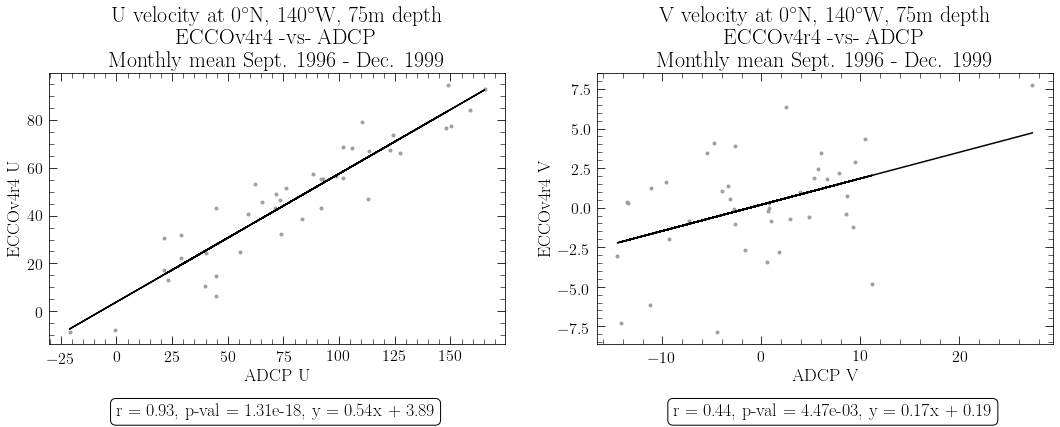

In [184]:
nrows=2
fig,axs = plt.subplots(1,2,figsize=(18,5))
#for fld, ax,xi,yi in zip(['uvel','vvel'],axs,[167,85],[-15,-23]):
for fld, ax,xi,yi,lbl,lbl2 in zip(['uvel','vvel'],axs,[.3,.73],[-.075,-.075],['U','V'],['Zonal','Meridional']):
    x = adcp[fld].resample({'time':'1m'}).mean().dropna('time')
    y = eds[fld].resample({'time':'1m'}).mean().dropna('time')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    ax.scatter(x,y,marker='.',color=[.6, .6, .6],alpha=.9)
    ax.plot(x,slope*x+intercept,color='black',linewidth=1.5)
    
    plt.figtext(xi,yi,f'r = {r_value:.2f}, p-val = {p_value:.2e}, y = {slope:.2f}x + {intercept:.2f}',
           horizontalalignment='center',bbox={'boxstyle':'round','facecolor':'white'})
    ax.set(xlabel=f'ADCP {lbl}',ylabel=f'ECCOv4r4 {lbl}',
           title=f'{lbl} velocity at 0$^\circ$N, 140$^\circ$W, 75m depth\nECCOv4r4 -vs- ADCP\nMonthly mean Sept. 1996 - Dec. 1999')

nice_inward_ticks(ax=axs[0],xminor_skip=5,yminor_skip=5)
nice_inward_ticks(ax=axs[1],xminor_skip=2,yminor_skip=.5)
fig.savefig('../figures/eccov4r4_adcp_regress_uv_monthly_75m_140w.png',bbox_inches='tight',dpi=300)

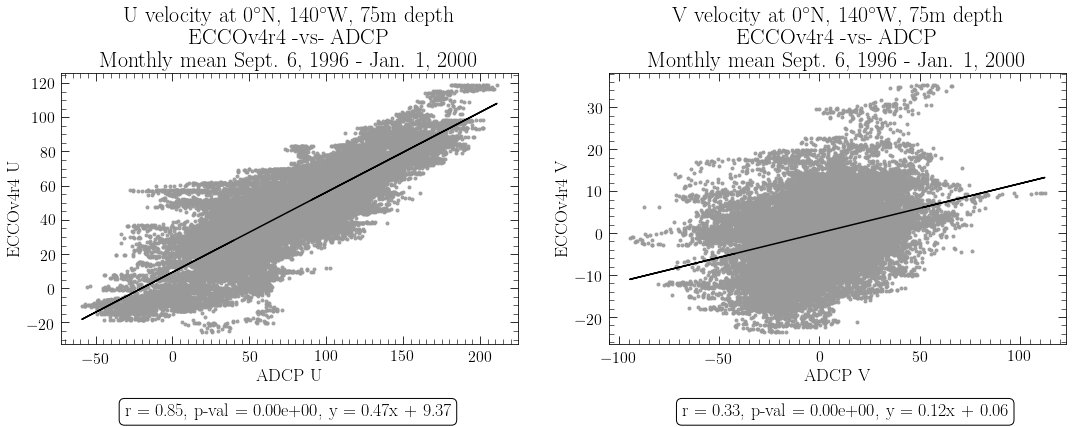

In [183]:
nrows=2
fig,axs = plt.subplots(1,2,figsize=(18,5))
#for fld, ax,xi,yi in zip(['uvel','vvel'],axs,[167,85],[-15,-23]):
for fld, ax,xi,yi,lbl,lbl2 in zip(['uvel','vvel'],axs,[.3,.73],[-.075,-.075],['U','V'],['Zonal','Meridional']):
    x = adcp[fld].dropna('time')
    y = eds[fld].dropna('time')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    ax.scatter(x,y,marker='.',color=[.6, .6, .6],alpha=.9)
    ax.plot(x,slope*x+intercept,color='black',linewidth=1.5)
    plt.figtext(xi,yi,f'r = {r_value:.2f}, p-val = {p_value:.2e}, y = {slope:.2f}x + {intercept:.2f}',
           horizontalalignment='center',bbox={'boxstyle':'round','facecolor':'white'})
    ax.set(xlabel=f'ADCP {lbl}',ylabel=f'ECCOv4r4 {lbl}',
           title=f'{lbl} velocity at 0$^\circ$N, 140$^\circ$W, 75m depth\nECCOv4r4 -vs- ADCP\nMonthly mean Sept. 6, 1996 - Jan. 1, 2000')

nice_inward_ticks(ax=axs[0],xminor_skip=5,yminor_skip=5)
nice_inward_ticks(ax=axs[1],xminor_skip=5,yminor_skip=2)
fig.savefig('../figures/eccov4r4_adcp_regress_uv_hourly_75m_140w.png',bbox_inches='tight',dpi=300)

In [169]:
ax.get_window_extent()